In [33]:
%pwd

'/cs/labs/guykatz/idopinto12/projects/loop_invariant_generation/RLInv'

In [34]:
import pandas as pd
df23 = pd.read_json('./dataset/evaluation/uautomizer23_evaluation_k3_rewrite/uautomizer23_evaluation_k3_rewrite.json')
df24 = pd.read_json('./dataset/evaluation/uautomizer24_evaluation_k3_rewrite/uautomizer24_evaluation_k3_rewrite.json')
df25 = pd.read_json('./dataset/evaluation/uautomizer25_evaluation_k3_rewrite/uautomizer25_evaluation_k3_rewrite.json')
df25.head()

,file,orig_program,rf_program,result,reason,timings,invariants,split
0,geo1-ll_unwindbound1_2.c,/*\nGeometric Series\ncomputes x=(z-1)* sum(z^...,void assert(int cond) { if (!(cond)) { ERROR :...,TRUE,,"{'all': [56.63986524590291, 52.75168537790887,...","[{'line': 14, 'invariant': '(((((y == ((long l...",hard
1,prodbin-ll_unwindbound1_2.c,/* shift_add algorithm for computing the\n p...,void assert(int cond) { if (!(cond)) { ERROR :...,TRUE,,"{'all': [12.101462388178334, 9.04833079315722,...","[{'line': 13, 'invariant': '(((1 <= counter) &...",easy
2,egcd2-ll_valuebound50_2.c,/* extended Euclid's algorithm */\nextern void...,void assert(int cond) { if (!(cond)) { ERROR :...,TRUE,,"{'all': [455.4383596321568, 452.9313368371222,...","[{'line': 24, 'invariant': '(((((((__int128) b...",hard
3,condmf_1.c,/*\n * Benchmarks contributed by Divyesh Unadk...,void assert(int cond) { if (!(cond)) { ERROR :...,FALSE,,"{'all': [7.26084141805768, 6.236475080950186, ...",[],easy
4,cohencu-ll_valuebound100_9.c,"/*\nPrinting consecutive cubes, by Cohen\nhttp...",void assert(int cond) { if (!(cond)) { ERROR :...,TRUE,,"{'all': [30.630973393796012, 31.05711368191987...","[{'line': 12, 'invariant': '((((((((((__int128...",hard


In [35]:
result_counts_25 = df25['result'].value_counts()
print(result_counts_25)


result
TRUE       176
FALSE       32
TIMEOUT     11
ERROR        1
Name: count, dtype: int64


In [36]:
result_counts_24 = df24['result'].value_counts()
print(result_counts_24)

result
TRUE       169
FALSE       32
TIMEOUT     18
ERROR        1
Name: count, dtype: int64


In [37]:
result_counts_23 = df23['result'].value_counts()
print(result_counts_23)


result
TRUE       170
FALSE       33
TIMEOUT     17
Name: count, dtype: int64


In [38]:
# Find intersection of files with "TIMEOUT" result in 23, 24, 25

timeout_23 = set(df23[df23["result"] == "TIMEOUT"]["file"])
timeout_24 = set(df24[df24["result"] == "TIMEOUT"]["file"])
timeout_25 = set(df25[df25["result"] == "TIMEOUT"]["file"])

intersection_timeout = timeout_23 & timeout_24 & timeout_25

print("Programs with TIMEOUT in all years:", intersection_timeout)
print("Number of such programs:", len(intersection_timeout))


Programs with TIMEOUT in all years: {'poly1_1.c', 'dll-simple-white-blue-2_2.c', 'hard2_4.c', 'sll-queue-1_13.c'}
Number of such programs: 4


/tmp/ipykernel_566235/3685840823.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


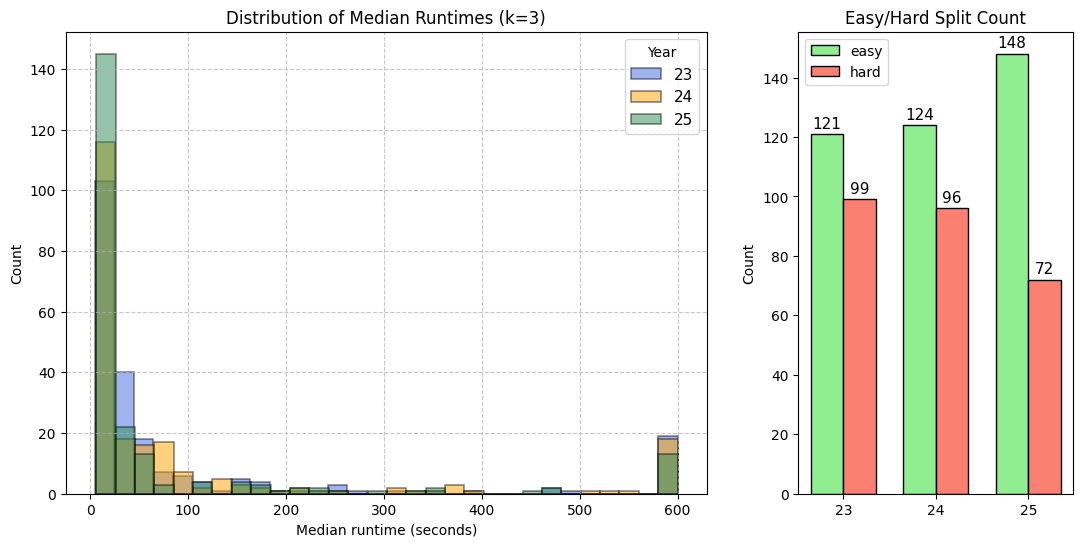

In [39]:
import matplotlib.pyplot as plt

def plot_median_timings_distributions_with_split(dfs, years, colors=None):
    """
    Plots the distribution of timings['median'] for multiple dataframes (years)
    and adds bar plots showing the number of 'easy' and 'hard' splits for each year.

    Args:
        dfs (list): List of DataFrame objects
        years (list): List of labels (strings) for each dataframe (e.g. [23, 24, 25])
        colors (list): List of color strings for each distribution (optional)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if colors is None:
        colors = ['royalblue', 'orange', 'seagreen']

    # Prepare median data
    median_lists = []
    for df in dfs:
        medians = df['timings'].apply(lambda x: x.get('median', None)).dropna()
        median_lists.append(medians)

    # --- Plotting ---
    fig = plt.figure(figsize=(13, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=(2.8, 1.2), wspace=0.2)

    # 1. Plot the histograms for median timings (left)
    ax0 = fig.add_subplot(gs[0])
    bins = 30
    for i, year in enumerate(years):
        ax0.hist(median_lists[i], bins=bins, color=colors[i%len(colors)], alpha=0.5, 
                 edgecolor='black', label=f"{year}", linewidth=1.1)
    ax0.set_title("Distribution of Median Runtimes (k=3)")
    ax0.set_xlabel("Median runtime (seconds)")
    ax0.set_ylabel("Count")
    ax0.grid(True, linestyle='--', alpha=0.7)
    ax0.legend(title="Year", fontsize=11)

    # 2. Plot the easy/hard split count (right)
    ax1 = fig.add_subplot(gs[1])
    
    # compute counts
    splits_per_year = []
    for df in dfs:
        val_counts = df['split'].value_counts()
        easy = val_counts.get('easy', 0)
        hard = val_counts.get('hard', 0)
        splits_per_year.append([easy, hard])
    splits_per_year = np.array(splits_per_year)
    widths = 0.35
    x = np.arange(len(years))

    ax1.bar(x - widths/2, splits_per_year[:,0], width=widths, label='easy', color='lightgreen', edgecolor='black')
    ax1.bar(x + widths/2, splits_per_year[:,1], width=widths, label='hard', color='salmon', edgecolor='black')

    # Add value labels above bars
    for i in range(len(years)):
        ax1.text(x[i] - widths/2, splits_per_year[i,0]+1, str(splits_per_year[i,0]), ha='center', va='bottom', fontsize=11)
        ax1.text(x[i] + widths/2, splits_per_year[i,1]+1, str(splits_per_year[i,1]), ha='center', va='bottom', fontsize=11)

    ax1.set_xticks(x)
    ax1.set_xticklabels(years)
    ax1.set_ylabel('Count')
    ax1.set_title("Easy/Hard Split Count")
    ax1.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_median_timings_distributions_with_split([df23, df24, df25], ["23", "24", "25"])